<a href="https://colab.research.google.com/github/darja/NeuralUni/blob/master/08_custom_dataset_ryazhskikh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация типов кораблей

Датасет состоит из изображений 400х400 со следующими типами кораблей:
* Контейнеровоз (Cargo)
* Судно береговой охраны (Coast Guard)
* Паром (Ferry)
* Рыболовецкое судно (Fishing)
* Буксир (Tug)

[Ссылка на датасет](https://drive.google.com/file/d/1zTKU96uN_P-YJhq3xZ8-uOP1uMe_nYcd/view?usp=sharing)

In [0]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.python.keras.optimizers import Adam, SGD
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

from google.colab import files
import numpy as np
import glob
import imageio
import datetime


import matplotlib.pyplot as plt
%matplotlib inline 

from keras import backend as K

# Подготовка данных

## Загрузка данных с Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!cp /content/gdrive/'My Drive'/neural/boatset.zip boatset.zip
!unzip boatset.zip
# !rm -rf __MACOSX
# !rm -rf .DS_Store

## Входные параметры

In [0]:
# K.clear_session()

# Пути к изображениям
root_folder = "boatset"
train_folder = root_folder + '/train'
val_folder = root_folder + '/val'
test_folder = root_folder + "/test"


# Размеры изображений
image_height, image_width = 400, 400
target_size = (image_height, image_width)
target_shape = (image_height, image_width, 3)

# Классы изображений
num_classes = 5
classes = {0: "Контейнеровоз", 1: "Береговая охрана", 2: "Паром", 3: "Рыболовецкое судно", 4: "Буксир"}

# Другое
batch_size = 8
lr = 2e-4
optimizer = Adam(lr)
# optimizer = RMSprop(lr)

## Генератор изображений

In [121]:
# Train generator
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size = target_size,
    batch_size = batch_size,
    class_mode = 'categorical')

print("Train classes", train_generator.class_indices)

# Validation generator
val_datagen = ImageDataGenerator(rescale=1. / 255)

val_generator = val_datagen.flow_from_directory(
    val_folder,
    target_size = target_size,
    batch_size = batch_size,
    class_mode = 'categorical'
)
print("Val classes", train_generator.class_indices)

Found 995 images belonging to 5 classes.
Train classes {'cargo': 0, 'coast guard': 1, 'ferry': 2, 'fishing': 3, 'tug': 4}
Found 160 images belonging to 5 classes.
Val classes {'cargo': 0, 'coast guard': 1, 'ferry': 2, 'fishing': 3, 'tug': 4}


# Подготовка нейросети

## Создание нейросети

### Нейросеть на основе Inception

In [0]:
def create_model():
    print("Loading Inception")

    base_model = InceptionV3(
      weights='imagenet', 
      include_top=False, 
      input_shape=target_shape)

    for layer in base_model.layers:
      layer.trainable = False

    print("Inception loaded")

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    return Model(inputs=base_model.input, outputs=predictions)


    return model

def load_trained_model(weights_path):
    model = create_model()
    model.load_weights(weights_path)
    return model

### Callbacks

In [123]:
opt_string = optimizer
if (type(optimizer) == Adam):
    opt_string = "adam_%.0E" % lr
elif (type(optimizer) == RMSprop):
    opt_string = "rmsprop_%.0E" % lr

dt = datetime.datetime.now().strftime('%Y%m%d-%H%M')
log_file = 'training.%s.batch_%s.%s.log' % (opt_string, batch_size, dt)
weights_file = 'shipnet.%s.batch_%s.%s.h5' % (opt_string, batch_size, dt)

print("Logging to [%s], saving network to [%s]" % (log_file, weights_file))
    
checkpoint = ModelCheckpoint(
    weights_file,                           
    monitor='val_acc',
    save_best_only=True,
    verbose = 1)

learning_rate = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=5, 
    verbose=1, 
    mode='auto',
    min_lr=1e-6)

csv_logger = CSVLogger(log_file)

callbacks = [checkpoint,learning_rate,csv_logger]

Logging to [training.adam_2E-04.batch_8.20190323-2306.log], saving network to [shipnet.adam_2E-04.batch_8.20190323-2306.h5]


## Обучение нейросети

Loading Inception
Inception loaded
Epoch 1/30
20/20 [==============================] - 9s 449ms/step - loss: 0.9861 - acc: 0.6187

Epoch 00001: val_acc improved from -inf to 0.61875, saving model to shipnet.adam_2E-04.batch_8.20190323-2306.h5
125/125 [==============================] - 734s 6s/step - loss: 1.2094 - acc: 0.5276 - val_loss: 0.9861 - val_acc: 0.6187
Epoch 2/30
20/20 [==============================] - 4s 187ms/step - loss: 0.8102 - acc: 0.7063

Epoch 00002: val_acc improved from 0.61875 to 0.70625, saving model to shipnet.adam_2E-04.batch_8.20190323-2306.h5
125/125 [==============================] - 29s 231ms/step - loss: 0.8349 - acc: 0.7025 - val_loss: 0.8102 - val_acc: 0.7063
Epoch 3/30
20/20 [==============================] - 4s 184ms/step - loss: 0.8294 - acc: 0.7250

Epoch 00003: val_acc improved from 0.70625 to 0.72500, saving model to shipnet.adam_2E-04.batch_8.20190323-2306.h5
125/125 [==============================] - 29s 228ms/step - loss: 0.6756 - acc: 0.7608 - 

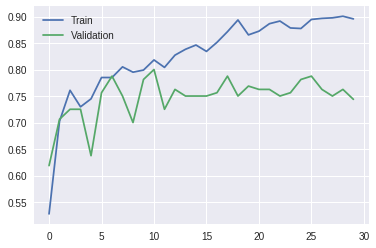

In [125]:
model = create_model()

model.compile(loss='categorical_crossentropy',
            optimizer=optimizer, 
            metrics=['accuracy'])


history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = val_generator, 
    validation_steps = val_generator.samples // batch_size,
    epochs = 30,
    verbose = 1,
    callbacks = callbacks
)

plt.plot(history.history['acc'], label='Train')
plt.plot(history.history['val_acc'], label='Validation')
plt.legend()
plt.show()

# Демонстрация распознавания

## Утилиты

In [0]:
def evaluate_folder(folder):
  datagen = ImageDataGenerator(rescale=1./255)
  generator = datagen.flow_from_directory(
    folder,
    target_size = target_size,
    batch_size = batch_size,
    shuffle = False,
    class_mode = 'categorical')
  generator.reset()
  print("Train classes", generator.class_indices)
  return model.evaluate_generator(
      generator, 
      steps = generator.samples // batch_size,
      verbose = 1)

def read_image(filename):
    return imageio.imread(filename)

def predict_single_image(content):
    x = content
    x = x / 255
    x = np.expand_dims(x, axis=0)
    
    prediction = model.predict(x)
    predicted = np.argmax(prediction, axis=-1)
    return predicted

## Загрузка наилучшей версии сети

In [128]:
print("Loading model from %s" % weights_file)
model = load_trained_model(weights_file)
model.compile(loss='categorical_crossentropy',
            optimizer=optimizer, 
            metrics=['accuracy'])

Loading model from shipnet.adam_2E-04.batch_8.20190323-2306.h5
Loading Inception
Inception loaded


## Распознавание размеченной выборки

In [129]:
print("---- Test ----\n")
train_eval = evaluate_folder(train_folder)

print("\n---- Validation ----\n")
val_eval = evaluate_folder(val_folder)


---- Test ----

Found 995 images belonging to 5 classes.
Train classes {'cargo': 0, 'coast guard': 1, 'ferry': 2, 'fishing': 3, 'tug': 4}
125/125 [==============================] - 27s 218ms/step - loss: 0.5254 - acc: 0.8101

---- Validation ----

Found 160 images belonging to 5 classes.
Train classes {'cargo': 0, 'coast_guard': 1, 'ferry': 2, 'fishing': 3, 'tug': 4}
20/20 [==============================] - 4s 181ms/step - loss: 0.5721 - acc: 0.8000


## Демонстрация

In [130]:
test_files = glob.glob(test_folder + "/*.jpg")
test_files.sort()

for filename in test_files:
    content = read_image(filename)
    cl = predict_single_image(content)[0]
    print("%s -> %s" % (filename, classes[cl]))


boatset/test/cargo_test_1.jpg -> Контейнеровоз
boatset/test/cargo_test_2.jpg -> Контейнеровоз
boatset/test/cargo_test_3.jpg -> Контейнеровоз
boatset/test/cargo_test_4.jpg -> Контейнеровоз
boatset/test/cargo_test_5.jpg -> Контейнеровоз
boatset/test/coast_guard_test_1.jpg -> Береговая охрана
boatset/test/coast_guard_test_2.jpg -> Буксир
boatset/test/coast_guard_test_3.jpg -> Береговая охрана
boatset/test/coast_guard_test_4.jpg -> Береговая охрана
boatset/test/coast_guard_test_5.jpg -> Буксир
boatset/test/ferry_test_1.jpg -> Паром
boatset/test/ferry_test_2.jpg -> Паром
boatset/test/ferry_test_3.jpg -> Паром
boatset/test/ferry_test_4.jpg -> Паром
boatset/test/ferry_test_5.jpg -> Паром
boatset/test/fishing_test_1.jpg -> Рыболовецкое судно
boatset/test/fishing_test_2.jpg -> Рыболовецкое судно
boatset/test/fishing_test_3.jpg -> Рыболовецкое судно
boatset/test/fishing_test_4.jpg -> Буксир
boatset/test/fishing_test_5.jpg -> Береговая охрана
boatset/test/tug_test_1.jpg -> Буксир
boatset/test/tug